# SETUP

In [216]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
import torch
from astropy.io import fits
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import ndimage as ndi
from skimage.util.shape import view_as_windows
import skimage.measure as skmeas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap
from numpy.lib.stride_tricks import as_strided
import pickle
from sklearn.mixture import GaussianMixture


## Load model

Properties of pre-trained model

In [2]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
model='VNET'
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 0
model_name = model
date_str = ""
save = '../saved_models_12052021_183655_/fold_' + str(k) + '_checkpoints/'

Load pre-trained model

In [20]:
! ls ../VNET__last_epoch.pth


LICENSE
Practice methods.ipynb
README.md
VNET__last_epoch.pth
__init__.py
__pycache__
cover_pic.png
data
data_generators
medzoo_imports
notebooks
plots
requirements.txt
run_segmentation
runs
saved_models
saved_models_12052021_165424_
saved_models_12052021_174938_
saved_models_12052021_182812_
saved_models_12052021_183655_
test--hisource-list-slidingwindowindices.txt
test.log
train_model.py
~$oject Description.docx


In [24]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.pretrained = pretrained
model_loc = "../VNET__last_epoch.pth"
# args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
args = argsclass('VNET', 'adam', 1e-2, 1, 2, model_loc)
model, optimizer = create_model(args)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45603934


3

In [4]:
train_df = pd.read_csv("../saved_models_12052021_183655_/fold_%s_checkpoints/VNET_/train.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models_12052021_183655_/fold_%s_checkpoints/VNET_/val.csv"%k, header=None, sep=":", names=["skip", "epoch", "loss", "dsc"])
train_df["epoch"] = train_df["epoch"].str.split("Loss", expand=True)[0]
val_df["epoch"] = val_df["epoch"].str.split("Loss", expand=True)[0]
train_df["loss"] = train_df["loss"].str.split(" ", expand=True)[0]
val_df["loss"] = val_df["loss"].str.split(" ", expand=True)[0]

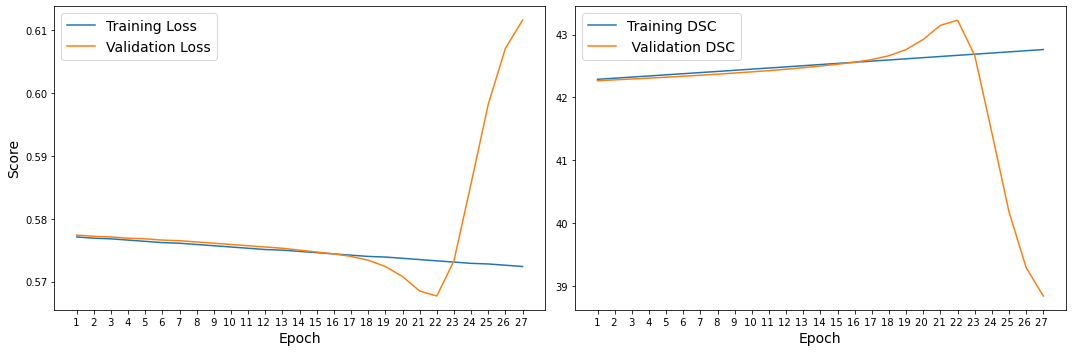

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

axes[0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[0].set_xlabel("Epoch", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Score", fontsize=14)
# axes[1].set_ylabel("Score")
axes[0].legend(fontsize=14)
axes[1].legend(fontsize=14)
fig.tight_layout()

## F-Score

In [41]:
def f_score(inter, all_of):
    dice = 2*inter/all_of
    return dice
def intersection(A, B):
    return np.nansum(np.logical_and(A, B).astype(int))

def all_AB(A, B):
    return np.nansum(A) + np.nansum(B)

# Evaluate Model

Load the test subcubes

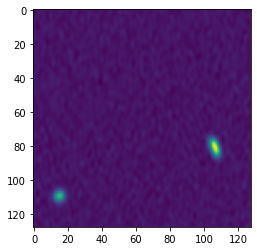

In [8]:
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
orig_subcube = orig_data[133:197, 800:800+128, 1500:1500+128]
real_subcube = realseg_data[133:197, 800:800+128, 1500:1500+128]
data_loader_tensor = torch.FloatTensor(np.moveaxis(orig_subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
plt.imshow(orig_subcube[32])

In [53]:
model.eval()
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
out_np = np.moveaxis(out_cube.squeeze()[0].numpy(), 2, 0)
smoothed_gal = ndi.gaussian_filter(out_np, sigma=0.01)
clipped = smoothed_gal > np.mean(smoothed_gal)+np.std(smoothed_gal)

In [54]:
gt = (real_subcube).flatten().tolist()
pred = (clipped).flatten().tolist()
f_score(intersection(gt, pred), all_AB(gt, pred))

0.7638397281608381

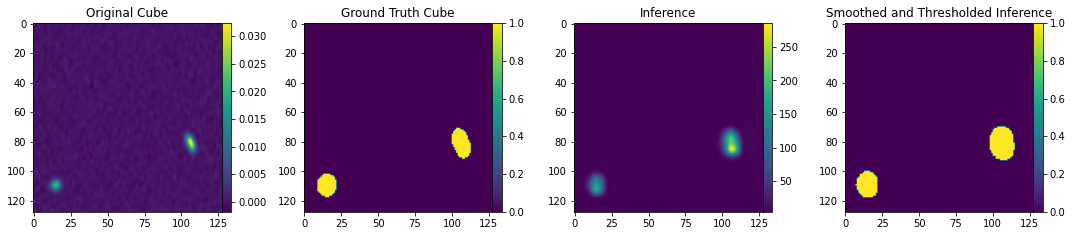

In [56]:
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
im0 = axes[0].imshow(orig_subcube[32])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")


im3 = axes[1].imshow(real_subcube[32])
cax3 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[1].set_title("Ground Truth Cube")

im1 = axes[2].imshow(out_np[32])
cax1 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[2].set_title("Inference")

im2 = axes[3].imshow(clipped[32])
cax2 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[3].set_title("Smoothed and Thresholded Inference")


# im4 = axes[4].imshow(out_mask.squeeze()[0][..., 34])
# cax4 = make_axes_locatable(axes[4]).append_axes("right", size="5%",pad=0)
# fig.colorbar(im4, cax=cax4)
# axes[4].set_title("Inference on GT")

# im5 = axes[5].imshow(object_labels_mask[..., 34])
# cax5 = make_axes_locatable(axes[5]).append_axes("right", size="5%",pad=0)
# fig.colorbar(im5, cax=cax5)
# axes[5].set_title("Post-Processed Inference on GT")

fig.tight_layout()

## Inference on a full cube

Stitch together sliding window

In [59]:
dims = [128, 128, 64]
overlaps = [15, 20, 20]
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")
test_file = "loud_1245mosC-slidingwindowindices.txt"
with open(test_file, "rb") as fp:
    test_list = pickle.load(fp)
for index, window in enumerate(test_list):
    test_list[index][0][0] = "." + window[0][0].replace("loudInput", "Input")
    test_list[index][0][1] = "." + window[0][1]
model.eval()
empty_arr = np.zeros((652, 1800, 2400))*np.nan

In [212]:
z_test_list = [i for i in test_list if i[3]==[176, 240]]
for index, window in enumerate(z_test_list):
    cube_files, x, y, z = window
    subcube = fits.getdata(cube_files[0])[z[0]:z[1], x[0]:x[1], y[0]:y[1]]
    input_tensor = torch.FloatTensor(np.moveaxis(subcube, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
    with torch.no_grad():
        out_cube = model.inference(input_tensor)
    out_np = np.moveaxis(out_cube.squeeze()[1].numpy(), 2, 0)
    empty_arr[z[0]:z[1], x[0]:x[1], y[0]:y[1]] = np.nanmean(np.array([empty_arr[z[0]:z[1], x[0]:x[1], y[0]:y[1]], out_np]), axis=0)
    print("\r", index*100/len(z_test_list), "%", end="")


 99.6969696969697 %%%%

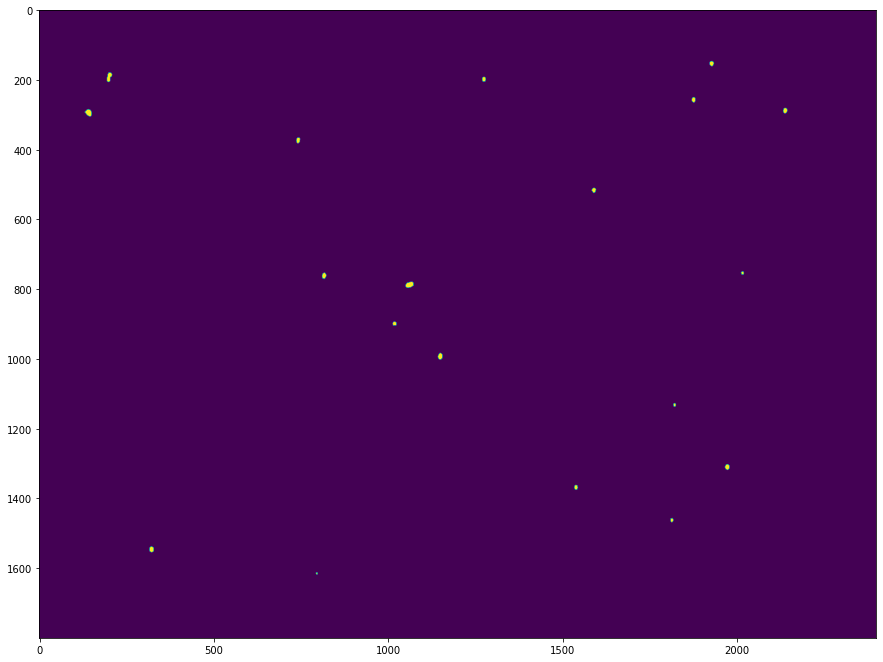

In [246]:
real_subcube = realseg_data[176:240]
orig_subcube = orig_data[176:240]
new_subcube = empty_arr[176:240]
binary_im = new_subcube > 0
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
axes.imshow(binary_im[32])

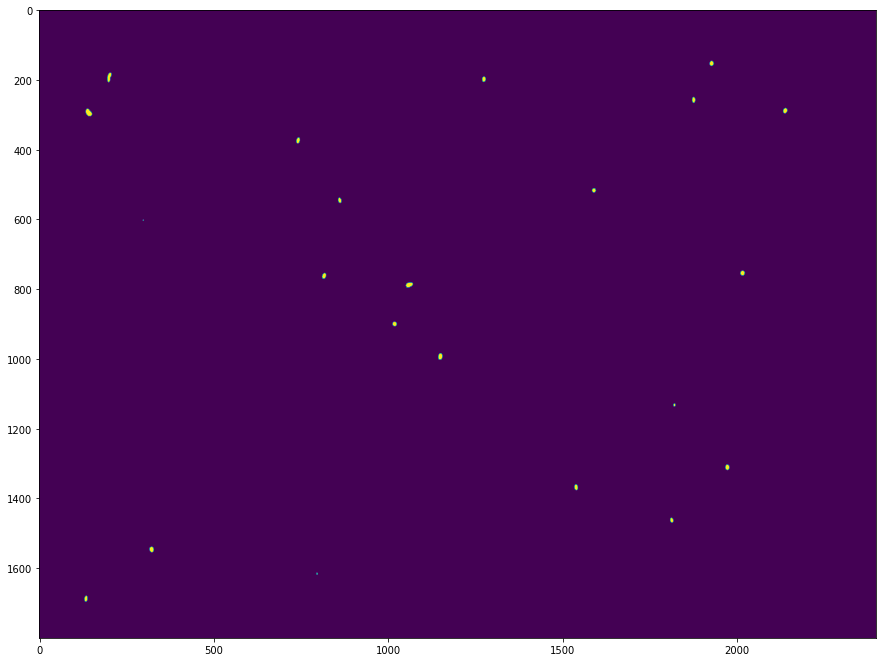

In [174]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
axes.imshow(realseg_data[176:240][32])

In [71]:
object_labels = skmeas.label(real_subcube)
print("Number of inserted sources =", len(np.unique(object_labels)))

Number of inserted sources = 67


Threshold and add limitations

In [211]:
def post_process_seg(new_subcube, orig_subcube):
    smoothed_gal = ndi.gaussian_filter(new_subcube, sigma=3)
    binary_im = smoothed_gal > np.nanmean(smoothed_gal) + np.nanstd(smoothed_gal)
    object_labels = skmeas.label(binary_im)
    some_props = skmeas.regionprops(object_labels)
    count = 0
    for i in range(len(some_props)):
        bb = some_props[i].bbox
        flux = np.nansum(orig_subcube[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]])
        cond = (bb[4]-bb[1] > 35) | (bb[5]-bb[2] > 35)|(flux < 0)
        if cond:
            binary_im[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]] = 0
        else:
            count += 1
    print("Number of found sources =", count)
    return binary_im

In [ ]:
binary_im = post_process_seg(new_subcube, orig_subcube)
object_labels = skmeas.label(binary_im)
print("Number of found sources =", len(np.unique(object_labels)))

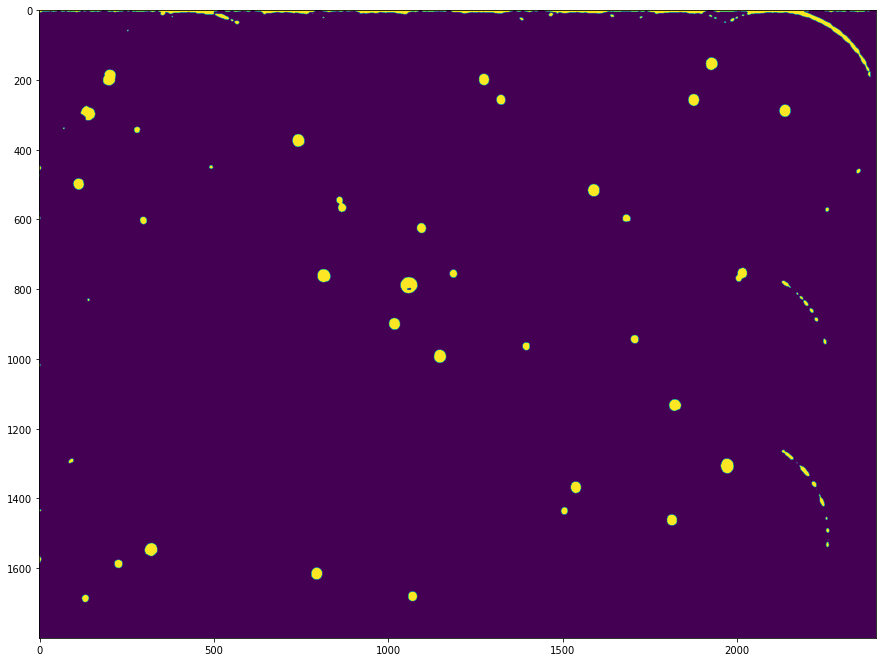

In [208]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
axes.imshow(binary_im[32])

View output

In [247]:
gt = (real_subcube).flatten().tolist()
pred = (binary_im).flatten().tolist()
score = f_score(intersection(gt, pred), all_AB(gt, pred))
score

0.7572570329343178